# Image Denoising

We'll demonstrate the use of a typical encoder–decoder by denoising a very noisy brightfield image of a single particle.

## Simulate Data

We use `Deeptrack 2.0` to simulate a spherical particle.

In [17]:
import deeptrack as dt
import numpy as np

particle = dt.Sphere(
    position=np.array([0.5, 0.5]) * 64,
    z=0,
    position_unit="pixel",
    radius=50e-8,
    refractive_index=1.45 + 0.02j,
)

We define the optical sysetm to image the particle.

### @Giovanni: In the original version we were providing examples about how to use DeepTrack for illumination gradient and coma, do we keep them? They are currently commented.

In [18]:
# illumination_gradient = dt.IlluminationGradient(
#     gradient=(0.01, 0.02),
#     constant=0.0,
# )

# aberr_coma = dt.HorizontalComa(
#     coefficient=1,
# )

spectrum = [500e-9]
brightfield_microscope = [
    dt.Brightfield(
        wavelength=wavelength,
        NA=1,
        resolution=1e-6,
        magnification=10,
        refractive_index_medium=1.33,
        upsample=2,
        output_region=(0, 0, 64, 64),
        # illumination=illumination_gradient,
        # pupil=aberr_coma,
    )
    for wavelength in spectrum
]

We create the sample by applying the optical system to the particle.

In [19]:
illuminated_sample = sum(
    [
        brightfield_microscope_onewl(particle)
        for brightfield_microscope_onewl in brightfield_microscope
    ]
)

We create a workflow to simulate _clean_ particle images. We also corrupt them with some Poisson noise to have their _noisy_ version. We join thetwo workflows in a simulation pipeline.

In [20]:
import torch

clean_particles = (
    illuminated_sample
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

noise = dt.Poisson(snr=lambda: 2.0 + np.random.rand() * 1)
noisy_particles = (
    illuminated_sample
    >> noise
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

pipeline = (noisy_particles) & (clean_particles)

We plot some generated samples.

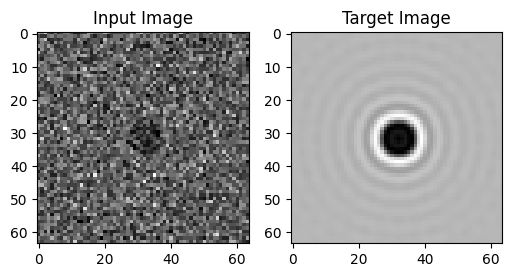

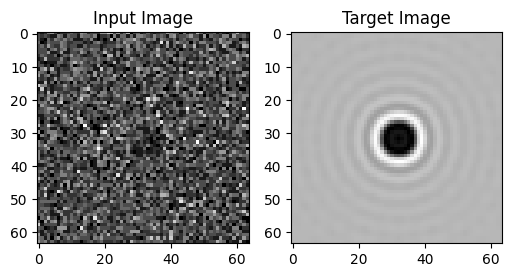

In [21]:
import matplotlib.pyplot as plt

for i in range(2):
    input, target = pipeline.update().resolve()
    plt.figure(figsize=(6, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input.permute(1, 2, 0), cmap="gray")
    plt.title("Input Image")
    plt.subplot(1, 2, 2)
    plt.imshow(target.permute(1, 2, 0), cmap="gray")
    plt.title("Target Image")

We define a dataset class that uses the simulation pipeline to generate data. When calling the class, we establish the size of dataset but also introduce the possibility to replace some of the initial data on the fly. In this way we can increase the amount of data that the network sees during the whole training while we keep the dataset size fixed at each epoch, thus establishing a trade off between simulation/training time and generalization ability.

In [22]:
from torch.utils.data import Dataset
import numpy as np


class SimulatedDatasetwithReplacement(Dataset):
    def __init__(self, pipeline, data_size, replace=0):
        self.images = [pipeline.update().resolve() for _ in range(data_size)]
        self.data_size = data_size
        self.pipeline = pipeline
        self.replace = replace

    def __len__(self):
        return self.data_size

    def __getitem__(self, idx):
        if np.random.rand() < self.replace:
            self.images[idx] = self.pipeline.update().resolve()
        noisy = self.images[idx][0]._value
        clean = self.images[idx][1]._value
        return (noisy, clean)

We create the datasets and the data loaders for the training and test sets.

In [23]:
from torch.utils.data import DataLoader

train_dataset = SimulatedDatasetwithReplacement(pipeline, data_size=256, replace=0.2)
test_dataset = SimulatedDatasetwithReplacement(pipeline, data_size=64)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

## Autoencoder
We define the autoencoder architecture.

In [24]:
import deeplay as dl
from torch.nn import Sigmoid

autoencoder = dl.ConvolutionalEncoderDecoder2d(
    in_channels=1,
    encoder_channels=[16, 16],
    decoder_channels=[16, 16],
    out_channels=1,
    out_activation=Sigmoid,
)
print(autoencoder)

ConvolutionalEncoderDecoder2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
      (1-2): 2 x PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
    )
    (post): Layer[Identity]()
  )
  (decoder): ConvolutionalDecoder2d(
    (pre): Layer[Identity]()
    (blocks): LayerList(
      (0-1): 2 x LayerActivationNormalizationUpsample(
        (layer): Layer[LazyConv2d](out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normali

We define the loss and the optimizer...

In [25]:
import torchmetrics as tm
from torch.nn import L1Loss


regressor_template = dl.Regressor(
    model=autoencoder,
    loss=L1Loss(),
    optimizer=dl.Adam(),
)

autoencoder_regressor = regressor_template.create()

... and start the training.

In [26]:
autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")

autoencoder_trainer.fit(autoencoder_regressor, train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type                          | Params
----------------------------------------------------------------
0 | loss          | L1Loss                        | 0     
1 | train_metrics | MetricCollection              | 0     
2 | val_metrics   | MetricCollecti

/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/841602/Documents/GitHub/Environments/deeplay_dev_env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=150` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


We visualize the autoencoder predictions.

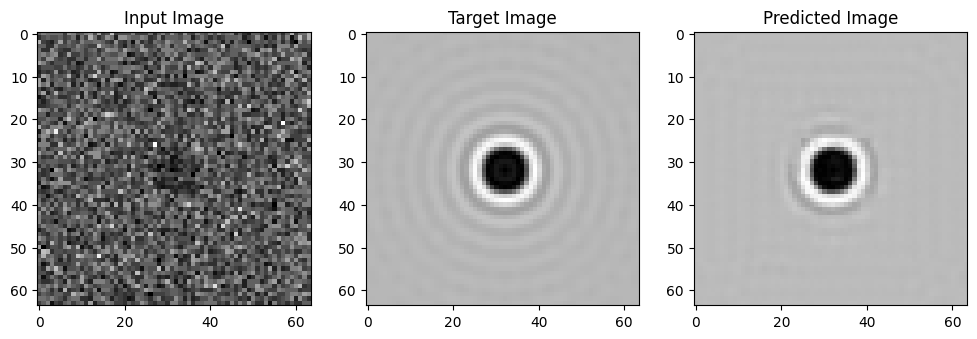

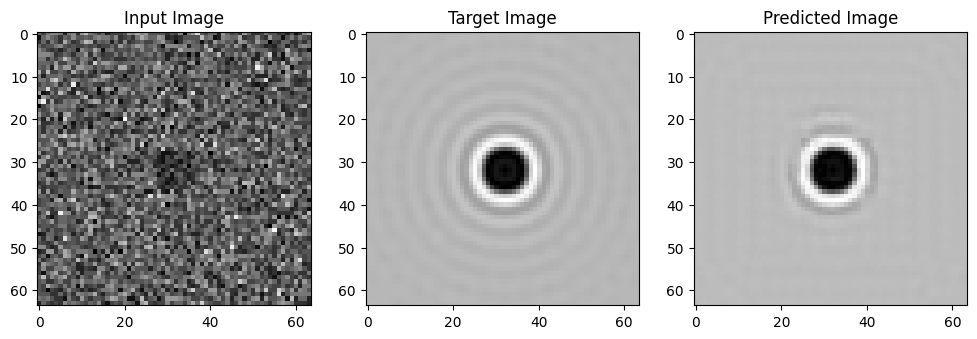

In [27]:
import matplotlib.pyplot as plt


for i in range(2):
    input_im, target_im = test_dataset[i]
    predicted_im = autoencoder_regressor(input_im).detach()
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

The training images are very similar. It can be that the autoencoder just learn to provide a centered particle, no matter what is the input (mode collapse). Let's check it out by making a prediction out of noise. 

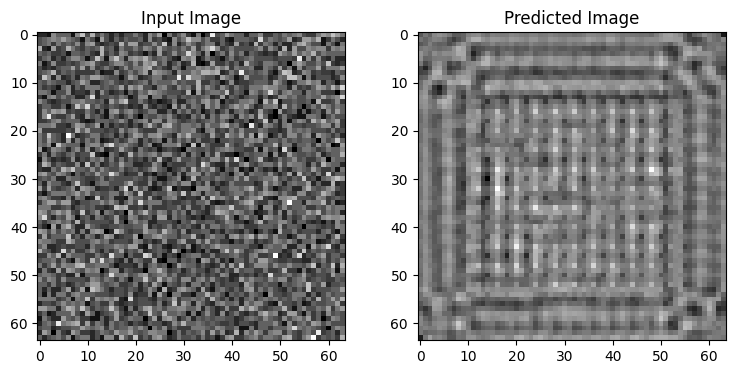

In [28]:
import torch

blank = sum(
    [
        brightfield_microscope_one_wl(particle ^ 0)
        for brightfield_microscope_one_wl in brightfield_microscope
    ]
)
blank_image = (
    blank
    >> noise
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)
blank_image = blank_image.update().resolve()  #
predicted_image = autoencoder_regressor(blank_image.unsqueeze(0)).detach()
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(blank_image[0, :, :], cmap="gray")
axs[0].set_title("Input Image")
axs[1].imshow(predicted_image[0, 0, :, :], cmap="gray")
axs[1].set_title("Predicted Image")
plt.show()

Let's see if the autoencoder is able to generalize its predictions to particles located off center and with different size.

In [29]:
new_particles = dt.Sphere(
    position=lambda: np.array([0.4, 0.4] + np.random.rand(2) * 0.2) * 64,
    z=0,
    position_unit="pixel",
    radius=lambda: 50e-8 + np.random.rand() * 50e-8,
    refractive_index=1.45 + 0.02j,
)

new_illuminated_sample = sum(
    [
        brightfield_microscope_onewl(new_particles)
        for brightfield_microscope_onewl in brightfield_microscope
    ]
)

new_clean_particles = (
    new_illuminated_sample
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

new_noisy_particles = (
    new_illuminated_sample
    >> noise
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

new_pipeline = (new_noisy_particles) & (new_clean_particles)

We check the predictions on this more challenging test set.

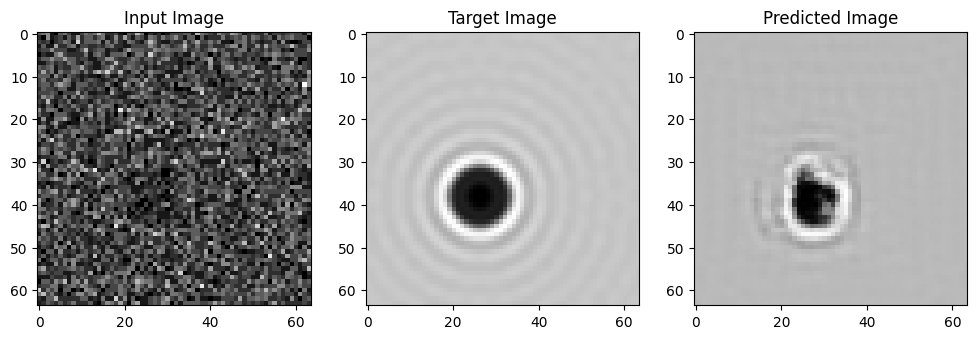

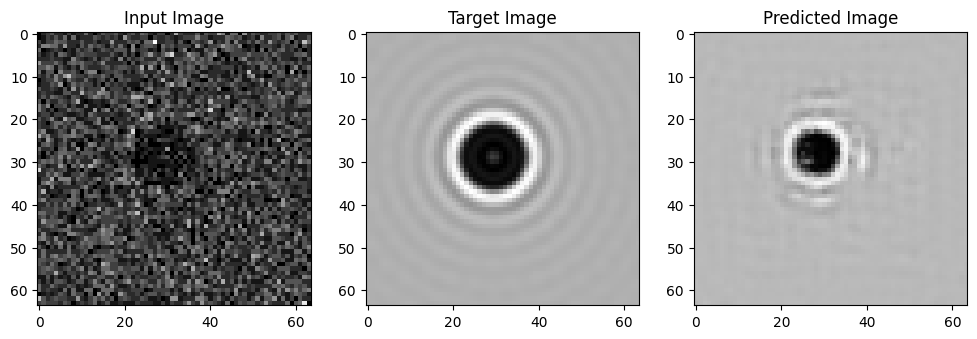

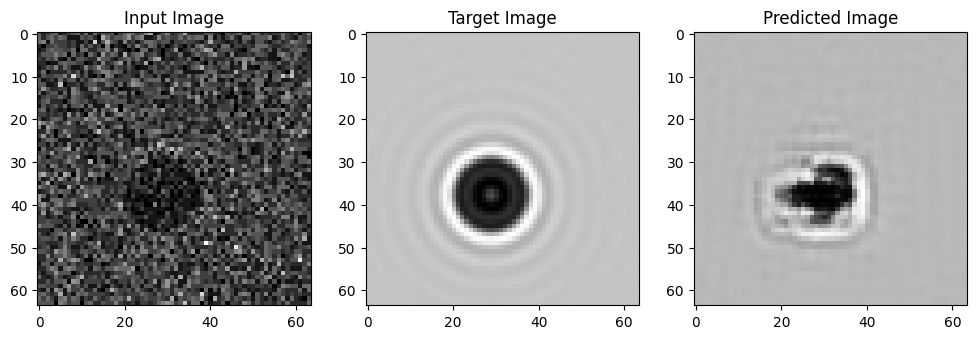

In [30]:
for _ in range(3):
    input_im, target_im = new_pipeline.update().resolve()
    predicted_im = autoencoder_regressor(input_im.unsqueeze(0)).detach()
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[0, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

We can train on the new dataset.

In [31]:
new_train_dataset = SimulatedDatasetwithReplacement(
    new_pipeline, data_size=256, replace=0.2
)

new_train_loader = DataLoader(new_train_dataset, batch_size=8, shuffle=True)

new_autoencoder_regressor = regressor_template.create()

new_autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")

new_autoencoder_trainer.fit(new_autoencoder_regressor, new_train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type                          | Params
----------------------------------------------------------------
0 | loss          | L1Loss                        | 0     
1 | train_metrics | MetricCollection              | 0     
2 | val_metrics   | MetricCollection              | 0     
3 | test_metrics  | MetricCollection              | 0     
4 | model         | ConvolutionalEncoderDecoder2d | 4.8 K 
5 | optimizer     | Adam                          | 0     
-------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=150` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


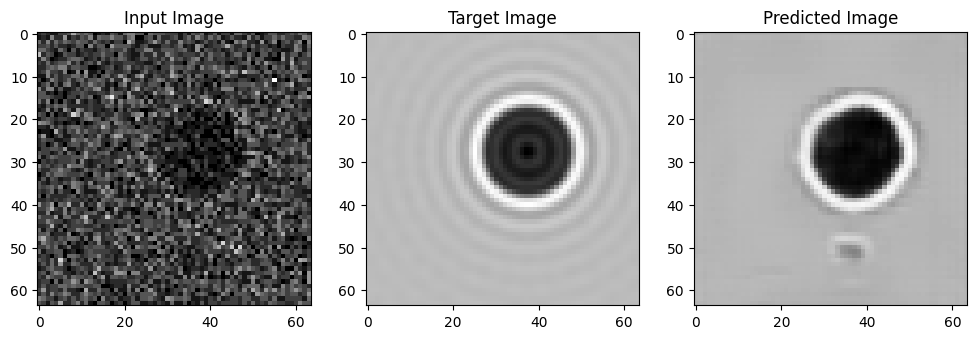

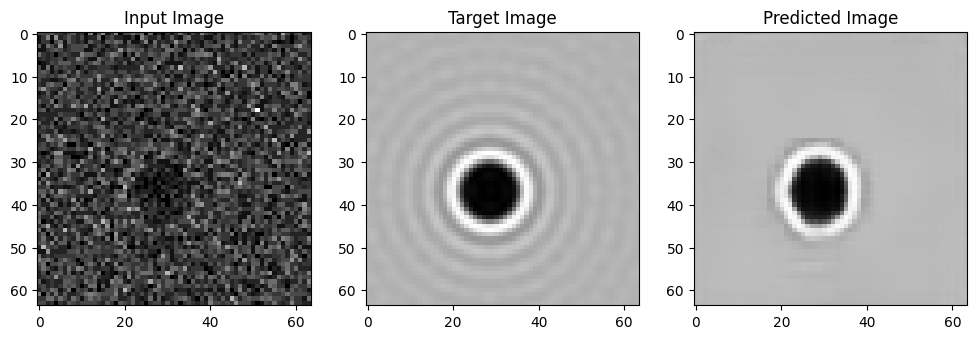

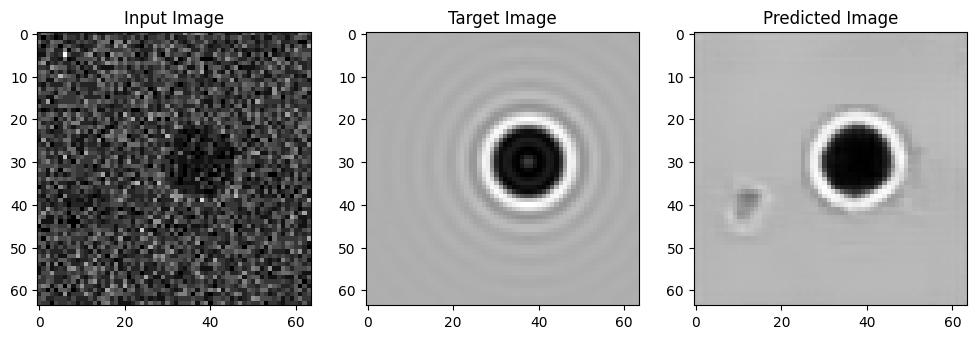

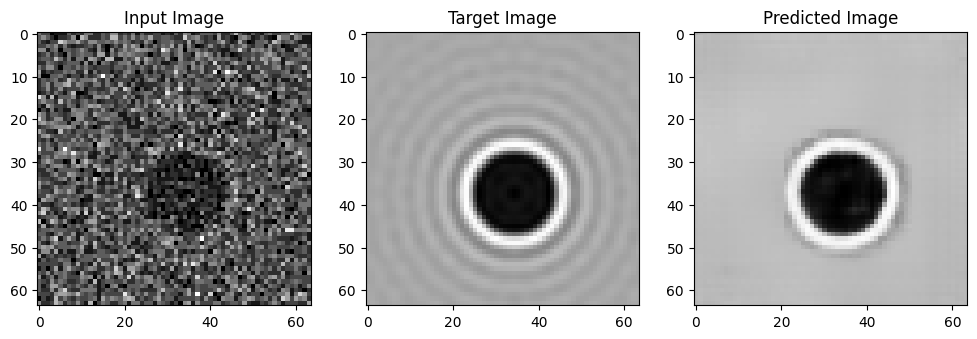

In [32]:
import matplotlib.pyplot as plt


for _ in range(4):
    input_im, target_im = new_pipeline.update().resolve()
    predicted_im = new_autoencoder_regressor(input_im.unsqueeze(0)).detach()
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[0, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")

## Improving the predictions
We can use a model with a larger number of activations to improve the results.

In [33]:
import deeplay as dl
from torch.nn import Sigmoid

better_autoencoder = dl.ConvolutionalEncoderDecoder2d(
    in_channels=1,
    encoder_channels=[8, 16, 32],
    decoder_channels=[32, 16, 8],
    out_channels=1,
    out_activation=Sigmoid,
)
print(better_autoencoder)

ConvolutionalEncoderDecoder2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=8)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=32)
      )
      (3): PoolLayerActivationNormalizat

In [34]:
better_regressor_template = dl.Regressor(
    model=better_autoencoder,
    loss=L1Loss(),
    optimizer=dl.Adam(),
)

better_autoencoder_regressor = better_regressor_template.create()

better_autoencoder_trainer = dl.Trainer(max_epochs=150, accelerator="auto")

better_autoencoder_trainer.fit(better_autoencoder_regressor, new_train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name          | Type                          | Params
----------------------------------------------------------------
0 | loss          | L1Loss                        | 0     
1 | train_metrics | MetricCollection              | 0     
2 | val_metrics   | MetricCollection              | 0     
3 | test_metrics  | MetricCollection              | 0     
4 | model         | ConvolutionalEncoderDecoder2d | 15.1 K
5 | optimizer     | Adam                          | 0     
-------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=150` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


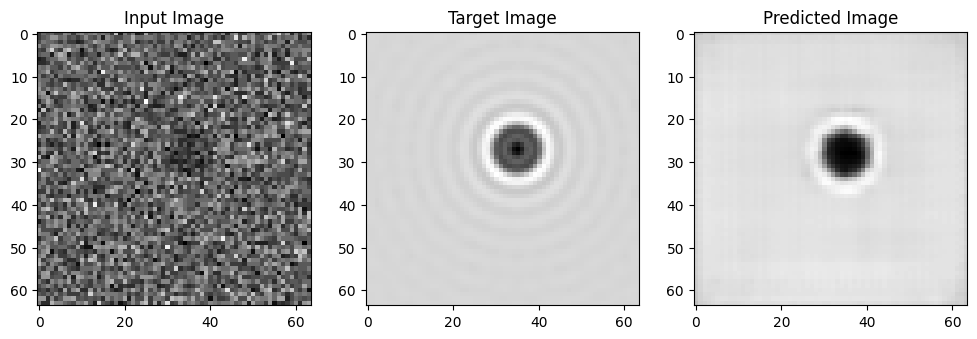

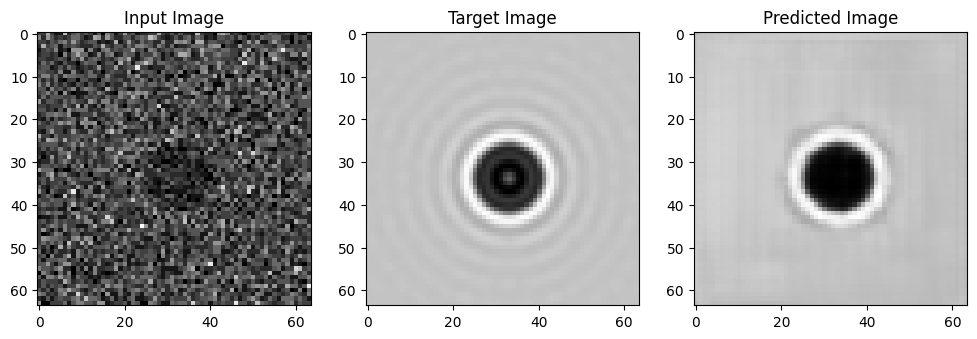

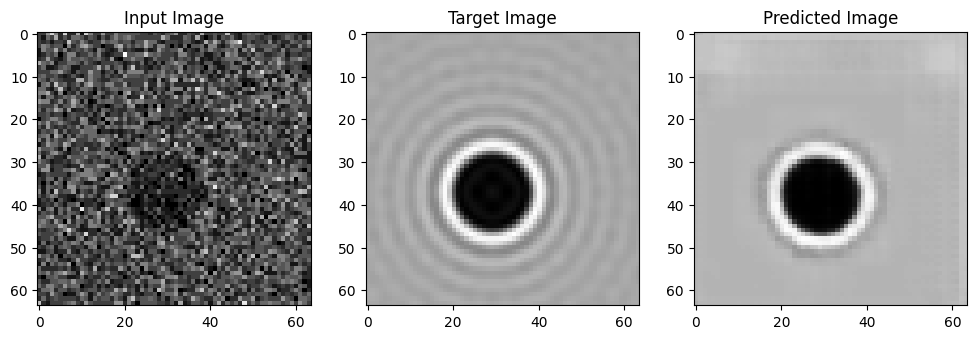

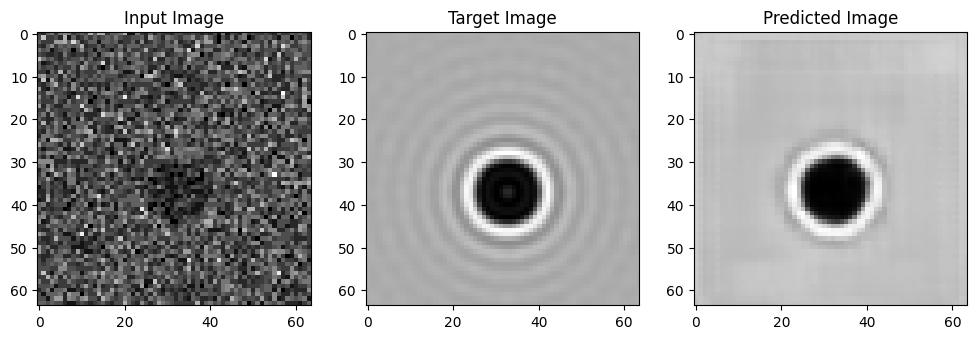

In [35]:
for _ in range(4):
    input_im, target_im = new_pipeline.update().resolve()
    predicted_im = better_autoencoder_regressor(input_im.unsqueeze(0)).detach()

    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(input_im[0, :, :], cmap="gray")
    axs[0].set_title("Input Image")
    axs[1].imshow(target_im[0, :, :], cmap="gray")
    axs[1].set_title("Target Image")
    axs[2].imshow(predicted_im[0, 0, :, :], cmap="gray")
    axs[2].set_title("Predicted Image")